In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import mplcyberpunk

In [101]:
train_df = pd.read_csv(r"..\data\train.csv", index_col=0)
test_df = pd.read_csv(r"..\data\test.csv", index_col=0)
sub = pd.read_csv(r"..\data\sample_submission.csv", index_col=0)

xgb_train_df = pd.read_csv(r'rendered_data/xgbregressor_train_submission.csv', index_col=0)
lgbm_train_df = pd.read_csv(r'rendered_data/lgbmregressor_train_submission.csv', index_col=0)
cat_train_df = pd.read_csv(r'rendered_data/catregressor_train_submission.csv', index_col=0)
lassocv_train_df = pd.read_csv(r'rendered_data/lassocvregressor_train_submission.csv', index_col=0)

xgb_test_df = pd.read_csv(r'rendered_data/xgbregressor_test_submission.csv', index_col=0)
lgbm_test_df = pd.read_csv(r'rendered_data/lgbmregressor_test_submission.csv', index_col=0)
cat_test_df = pd.read_csv(r'rendered_data/catregressor_test_submission.csv', index_col=0)
lassocv_test_df = pd.read_csv(r'rendered_data/lassocvregressor_test_submission.csv', index_col=0)

In [109]:
regressors = [
    'xgbregressor', 
    'lgbmregressor', 
    'catregressor', 
    'lassocvregressor',
]

In [110]:
features = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction','HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
        'BusinessTravel_v', 'Department_v', 'EducationField_v','Gender_v', 'JobRole_v', 'MaritalStatus_v', 'OverTime_v']
target = ['Attrition']

In [122]:
# Join oof preds
oof_df = pd.DataFrame(index=np.arange(len(train_df.index)))
for i in regressors:
    df = pd.read_csv(f"rendered_data/{i}_train_submission.csv", index_col=0)
    df.rename(columns={"Attrition": i}, inplace=True)
    oof_df = pd.concat([oof_df,df], axis=1)
    
# Join test preds
test_preds = pd.DataFrame()
for i in regressors:
    df = pd.read_csv(f"rendered_data/{i}_test_submission.csv", index_col=0)
    df.rename(columns={"Attrition": i}, inplace=True)
    test_preds = pd.concat([test_preds,df], axis=1)
    
oof_df.head(3)

,xgbregressor,lgbmregressor,catregressor,lassocvregressor
0,0.201263,0.138759,0.078111,-101.449181
1,0.085452,0.052934,-0.000738,-166.206111
2,0.061409,0.027624,-0.007162,-235.606977


In [123]:
# Evaluate oof preds
scores = {}
for col in oof_df.columns:
    scores[col] = roc_auc_score(train_df[target], oof_df[col])

# Sort scores
scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1], reverse=True)}

# Sort oof_df and test_preds
oof_df = oof_df[list(scores.keys())]
test_preds = test_preds[list(scores.keys())]

scores

{'catregressor': 0.7872088693297224,
 'xgbregressor': 0.7534614082599864,
 'lgbmregressor': 0.7407498307379824,
 'lassocvregressor': 0.5773155044008124}

In [124]:
oof_df.iloc[:,0:].copy()

,catregressor,xgbregressor,lgbmregressor,lassocvregressor
0,0.078111,0.201263,0.138759,-101.449181
1,-0.000738,0.085452,0.052934,-166.206111
2,-0.007162,0.061409,0.027624,-235.606977
3,0.077308,0.107722,0.076225,-232.910934
4,0.136560,0.224334,0.201371,-440.928318
...,...,...,...,...
1672,0.076452,0.127632,0.094101,-267.661986
1673,0.029614,0.108115,0.086392,-231.158492
1674,0.175508,0.243313,0.206061,-210.983877
1675,0.007762,0.058857,0.046679,-122.332990


In [125]:
# Initialise
STOP = False
current_best_ensemble = oof_df.iloc[:,0].copy()
current_best_test_preds = test_preds.iloc[:,0].copy()
MODELS = oof_df.iloc[:,0:].copy()
history = []
history_names = []
i=0

# Hill climbing
while not STOP:
    i+=1
    potential_new_best_cv_score = roc_auc_score(train_df[target], current_best_ensemble)
    history.append(potential_new_best_cv_score)
    k_best, wgt_best = None, None
    for k in MODELS:
        for wgt in np.arange(-0.5,0.51,0.01):
            potential_ensemble = (1-wgt) * current_best_ensemble + wgt * MODELS[k]
            cv_score = roc_auc_score(train_df[target], potential_ensemble)
            if cv_score > potential_new_best_cv_score:
                potential_new_best_cv_score = cv_score
                k_best, wgt_best = k, wgt
            
    if k_best is not None:
        current_best_ensemble = (1-wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
        current_best_test_preds = (1-wgt_best) * current_best_test_preds + wgt_best * test_preds[k_best]
        MODELS.drop(k_best, axis=1, inplace=True)
        if MODELS.shape[1]==0:
            STOP = True
        print(f'Iteration: {i}, Model added: {k_best}, Best weight: {wgt_best:.2f}, Best AUC: {potential_new_best_cv_score:.5f}')
        history_names.append(k_best)
    else:
        STOP = True

Iteration: 1, Model added: xgbregressor, Best weight: 0.18, Best AUC: 0.78910
Iteration: 2, Model added: lgbmregressor, Best weight: -0.02, Best AUC: 0.78943
Iteration: 3, Model added: lassocvregressor, Best weight: 0.00, Best AUC: 0.78961
Iteration: 4, Model added: catregressor, Best weight: -0.02, Best AUC: 0.78969


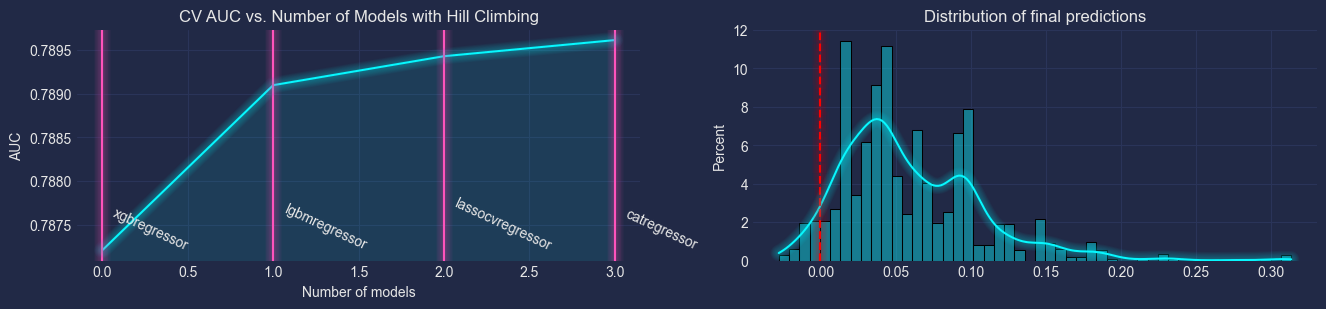

In [132]:
plt.style.use("cyberpunk")

n_cols = 2
n_rows = 1
cell_with_dim = 8
cell_height_dim = 3

histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':50
    }

fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
sns.lineplot(history, ax=ax[0])
sns.histplot(current_best_test_preds, **histplot_hyperparams, ax=ax[1])

ylim = ax[0].get_ylim()

for i, auc in enumerate(history):
    ax[0].axvline(x = i, color = '#FE53BB')
    ax[0].text(i + 0.05, ylim[0] + ((ylim[0] - ylim[1] ) * -0.05), history_names[i], fontsize=10, rotation=-25)

ax[0].set_ylim(ylim)


ax[1].axvline(x = 0, color = 'r', linestyle='--')

mplcyberpunk.make_lines_glow(ax[0])
mplcyberpunk.add_underglow(ax[0])
mplcyberpunk.make_lines_glow(ax[1])

ax[0].set_title("CV AUC vs. Number of Models with Hill Climbing")
ax[0].set_xlabel("Number of models")
ax[0].set_ylabel("AUC")
ax[1].set_title("Distribution of final predictions")


plt.show()

In [127]:
history

[0.7872088693297224,
 0.7890978334461747,
 0.7894295870006771,
 0.7896140825998644]

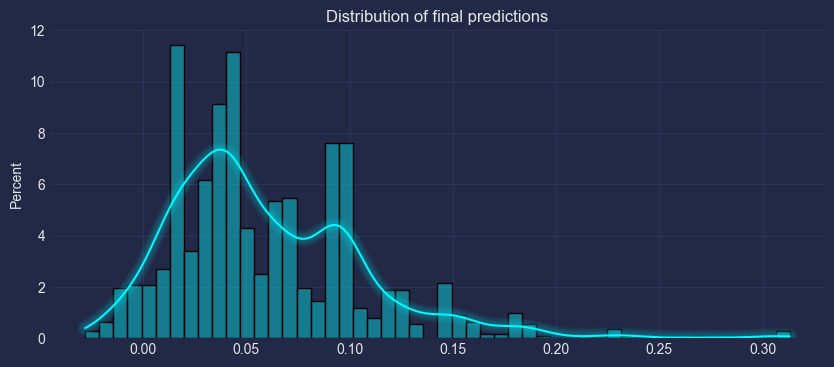

In [9]:
histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':50
    }

fig, ax = plt.subplots(1,figsize=(10,4))
sns.histplot(current_best_test_preds, **histplot_hyperparams)
plt.title("Distribution of final predictions")
mplcyberpunk.make_lines_glow(ax)
plt.show()

In [10]:
current_best_test_preds

id
1677    0.077475
1678    0.056297
1679    0.060353
1680    0.096777
1681    0.088057
          ...   
2791    0.029906
2792    0.042891
2793    0.014513
2794    0.002534
2795    0.040568
Length: 1119, dtype: float64

In [11]:
# Submit predictions
submission = sub.copy()
submission["Attrition"] = current_best_test_preds.values
submission.to_csv("submission.csv", index=True)